In [1]:
import sys
sys.path.append('/home/aarthivenkat/bin/Gene-Signal-Pattern-Analysis/')
import gspa

/home/aarthivenkat/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
import numpy as np
import scprep
import phate
import matplotlib.pyplot as plt

In [3]:
sim = scprep.run.splatter.SplatSimulate(method='groups', batch_cells=[1000, 1000],
                                            group_prob=[0.3,0.3,0.3], de_prob=0.6, seed=0,
                                            n_genes=10000, batch_fac_loc=0.1, batch_fac_scale=0.01) 

R[write to console]: Getting parameters...
R[write to console]: Creating simulation object...
R[write to console]: Simulating library sizes...
R[write to console]: Simulating gene means...
R[write to console]: Simulating batch effects...
R[write to console]: Simulating group DE...
R[write to console]: Simulating cell means...
R[write to console]: Simulating BCV...
R[write to console]: Simulating counts...
R[write to console]: Simulating dropout (if needed)...
R[write to console]: Sparsifying assays...
R[write to console]: Automatically converting to sparse matrices, threshold = 0.95
R[write to console]: Skipping 'BatchCellMeans': estimated sparse size 1.5 * dense matrix
R[write to console]: Skipping 'BaseCellMeans': estimated sparse size 1.5 * dense matrix
R[write to console]: Skipping 'BCV': estimated sparse size 1.5 * dense matrix
R[write to console]: Skipping 'CellMeans': estimated sparse size 1.49 * dense matrix
R[write to console]: Skipping 'TrueCounts': estimated sparse size 1.63

In [4]:
# number of cells with measurement of gene
gene_mask = (sim['counts'] > 0).sum(axis=0) > 50
# remove lowly expressed genes
data_expressed_genes = sim['counts'][:, gene_mask]
data_libnorm = scprep.normalize.library_size_normalize(data_expressed_genes)
data_libnorm_log = scprep.transform.log(data_libnorm)
data_libnorm_log = data_libnorm_log / np.linalg.norm(data_libnorm_log, axis=0) # L2 normalize genes

In [38]:
phate_op = phate.PHATE(random_state=42)
data_phate = phate_op.fit_transform(data_libnorm_log)

Calculating PHATE...
  Running PHATE on 2000 observations and 9383 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.30 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.33 seconds.
    Calculating affinities...
    Calculated affinities in 0.11 seconds.
  Calculated graph and diffusion operator in 1.75 seconds.
  Calculating optimal t...
    Automatically selected t = 7
  Calculated optimal t in 1.52 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.28 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 5.57 seconds.
Calculated PHATE in 9.13 seconds.


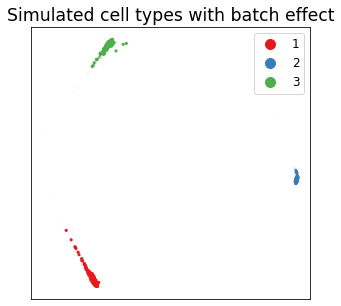

In [39]:
fig, ax = plt.subplots(figsize=(5,5))
scprep.plot.scatter2d(data_phate, c=sim['group'], ax=ax,
                      mask=sim['batch'] == 'Batch1', cmap='Set1')
scprep.plot.scatter2d(data_phate, c=sim['group'], ax=ax,
                      mask=sim['batch'] == 'Batch2', cmap='Set1',
                      marker='^', alpha=0.01, ticks=None, title='Simulated cell types with batch effect')
fig.savefig('figures/simulated_with_batch_effect.png', dpi=500)

In [40]:
batch_phate_op = phate.PHATE(random_state=42, sample_idx=sim['batch'], theta=0.9)
batch_data_phate = batch_phate_op.fit_transform(data_libnorm_log)

Calculating PHATE...
  Running PHATE on 2000 observations and 9383 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.25 seconds.
    Calculating subgraphs...
      Calculating KNN search...
      Calculated KNN search in 0.09 seconds.
      Calculating affinities...
      Calculated affinities in 0.03 seconds.
      Calculating KNN search...


/home/aarthivenkat/.local/lib/python3.8/site-packages/graphtools/base.py:515: UserWarning: kernel_symm='+' but theta is not None. Setting kernel_symm='mnn'.
  warnings.warn(


      Calculated KNN search in 0.08 seconds.
      Calculating affinities...
      Calculated affinities in 0.02 seconds.
    Calculated subgraphs in 0.24 seconds.
    Calculating MNN kernel...
      Calculating kernel from sample Batch1 to Batch2...
        Calculating KNN search...
        Calculated KNN search in 0.08 seconds.
        Calculating affinities...
        Calculated affinities in 0.04 seconds.
      Calculated kernel from sample Batch1 to Batch2 in 0.15 seconds.
      Calculating kernel from sample Batch2 to Batch1...
        Calculating KNN search...
        Calculated KNN search in 0.08 seconds.
        Calculating affinities...
        Calculated affinities in 0.04 seconds.
      Calculated kernel from sample Batch2 to Batch1 in 0.18 seconds.
    Calculated MNN kernel in 0.39 seconds.
  Calculated graph and diffusion operator in 1.94 seconds.
  Calculating optimal t...
    Automatically selected t = 7
  Calculated optimal t in 1.54 seconds.
  Calculating diffusion po

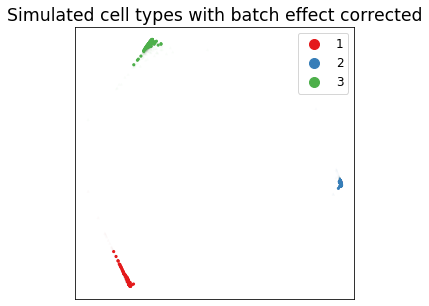

In [41]:
fig, ax = plt.subplots(figsize=(5,5))
scprep.plot.scatter2d(batch_data_phate, c=sim['group'], ax=ax,
                      mask=sim['batch'] == 'Batch1', cmap='Set1')
scprep.plot.scatter2d(batch_data_phate, c=sim['group'], ax=ax, cmap='Set1',
                      mask=sim['batch'] == 'Batch2', marker='^', alpha=0.01,
                      ticks=None, title='Simulated cell types with batch effect corrected')
fig.savefig('figures/simulated_with_batch_effect_corrected.png', dpi=500)

## Gene embeddings without batch correction

In [42]:
gspa_op = gspa.GSPA()
gspa_op.construct_graph(data_libnorm_log)
gspa_op.build_diffusion_operator()
gspa_op.build_wavelet_dictionary()
gene_signals = data_libnorm_log.T # embed all filtered genes
gene_ae, gene_pc = gspa_op.get_gene_embeddings(gene_signals)

Calculating PCA...
Calculated PCA in 1.34 seconds.
Calculating KNN search...
Calculated KNN search in 0.16 seconds.
Calculating affinities...
Calculated affinities in 0.10 seconds.


100%|██████████| 5/5 [00:02<00:00,  2.22it/s]


In [43]:
gene_phate_op = phate.PHATE(random_state=42)
gene_phate = gene_phate_op.fit_transform(gene_ae)

Calculating PHATE...
  Running PHATE on 9383 observations and 128 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.10 seconds.
    Calculating KNN search...
    Calculated KNN search in 7.67 seconds.
    Calculating affinities...
    Calculated affinities in 7.82 seconds.
  Calculated graph and diffusion operator in 15.65 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 3.18 seconds.
    Calculating KMeans...
    Calculated KMeans in 2.47 seconds.
  Calculated landmark operator in 7.19 seconds.
  Calculating optimal t...
    Automatically selected t = 7
  Calculated optimal t in 1.86 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.33 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.57 seconds.
Calculated PHATE in 29.61 seconds.


<Axes: >

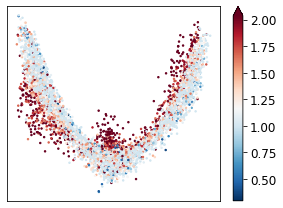

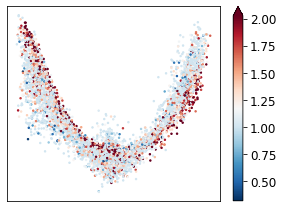

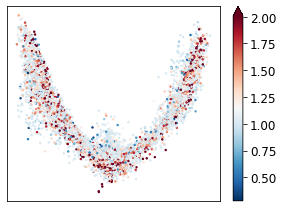

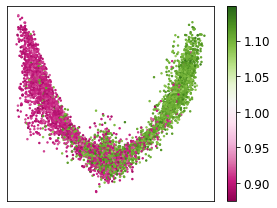

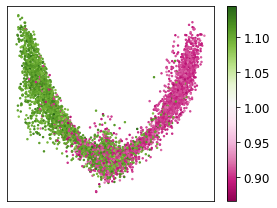

In [44]:
scprep.plot.scatter2d(gene_phate, c=sim['de_fac_1'][gene_mask], cmap='RdBu_r',
                      vmax=np.percentile(sim['de_fac_1'][gene_mask], 95), ticks=None, figsize=(4,3),
                      filename='figures/batch_effect_de_fac_1.png', dpi=500)
scprep.plot.scatter2d(gene_phate, c=sim['de_fac_2'][gene_mask], cmap='RdBu_r',
                      vmax=np.percentile(sim['de_fac_2'][gene_mask], 95), ticks=None, figsize=(4,3),
                      filename='figures/batch_effect_de_fac_2.png', dpi=500)
scprep.plot.scatter2d(gene_phate, c=sim['de_fac_3'][gene_mask], cmap='RdBu_r',
                      vmax=np.percentile(sim['de_fac_3'][gene_mask], 95), ticks=None, figsize=(4,3),
                     filename='figures/batch_effect_de_fac_3.png', dpi=500)
scprep.plot.scatter2d(gene_phate, c=sim['batch_fac_1'][gene_mask], ticks=None, figsize=(4,3),
                      filename='figures/batch_effect_batch_fac_1.png', dpi=500, cmap='PiYG')
scprep.plot.scatter2d(gene_phate, c=sim['batch_fac_2'][gene_mask], ticks=None, figsize=(4,3),
                      filename='figures/batch_effect_batch_fac_2.png', dpi=500, cmap='PiYG')

## Gene embeddings with batch correction

In [31]:
gspa_op = gspa.GSPA(bc_sample_idx=sim['batch'])
gspa_op.construct_graph(data_libnorm_log)
gspa_op.build_diffusion_operator()
gspa_op.build_wavelet_dictionary()
gene_signals = data_libnorm_log.T # embed all filtered genes
gene_ae, gene_pc = gspa_op.get_gene_embeddings(gene_signals)

In [32]:
batch_gene_phate_op = phate.PHATE(random_state=42)
batch_gene_phate = batch_gene_phate_op.fit_transform(gene_ae)

Calculating PHATE...
  Running PHATE on 9383 observations and 128 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.10 seconds.
    Calculating KNN search...
    Calculated KNN search in 7.72 seconds.
    Calculating affinities...
    Calculated affinities in 7.41 seconds.
  Calculated graph and diffusion operator in 15.29 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 2.87 seconds.
    Calculating KMeans...
    Calculated KMeans in 2.35 seconds.
  Calculated landmark operator in 6.56 seconds.
  Calculating optimal t...
    Automatically selected t = 23
  Calculated optimal t in 1.82 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.51 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 5.58 seconds.
Calculated PHATE in 29.77 seconds.


<Axes: >

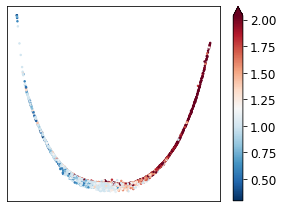

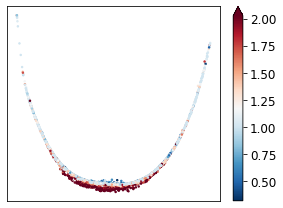

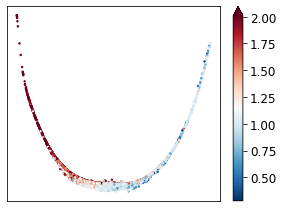

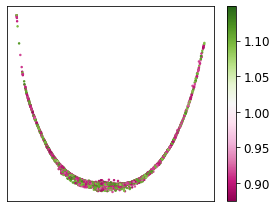

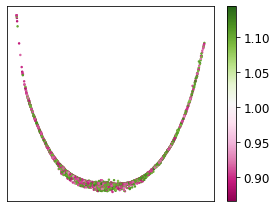

In [33]:
scprep.plot.scatter2d(batch_gene_phate, c=sim['de_fac_1'][gene_mask], cmap='RdBu_r',
                      vmax=np.percentile(sim['de_fac_1'][gene_mask], 95), ticks=None, figsize=(4,3),
                      filename='figures/batch_corrected_de_fac_1.png', dpi=500)
scprep.plot.scatter2d(batch_gene_phate, c=sim['de_fac_2'][gene_mask], cmap='RdBu_r',
                      vmax=np.percentile(sim['de_fac_2'][gene_mask], 95), ticks=None, figsize=(4,3),
                      filename='figures/batch_corrected_de_fac_2.png', dpi=500)
scprep.plot.scatter2d(batch_gene_phate, c=sim['de_fac_3'][gene_mask], cmap='RdBu_r',
                      vmax=np.percentile(sim['de_fac_3'][gene_mask], 95), ticks=None, figsize=(4,3),
                      filename='figures/batch_corrected_de_fac_3.png', dpi=500)
scprep.plot.scatter2d(batch_gene_phate, c=sim['batch_fac_1'][gene_mask], ticks=None, figsize=(4,3),
                      filename='figures/batch_corrected_batch_fac_1.png', dpi=500, cmap='PiYG')
scprep.plot.scatter2d(batch_gene_phate, c=sim['batch_fac_2'][gene_mask], ticks=None, figsize=(4,3),
                      filename='figures/batch_corrected_batch_fac_2.png', dpi=500, cmap='PiYG')

In [34]:
cluster_specificity_scores = {}
for group in [1,2,3]:
    group_signal = (sim['group'] == group).astype(int)
    cluster_specificity_scores[group] = gspa_op.calculate_cell_type_specificity(cell_type_assignments=sim['group'],
                                                                                cell_type=group)

Computing cell type specificity with signals used for gene embedding
Computing cell type specificity with signals used for gene embedding
Computing cell type specificity with signals used for gene embedding


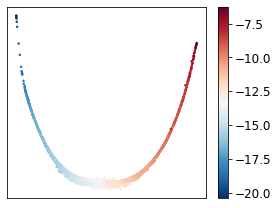

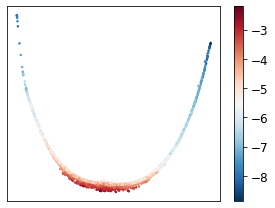

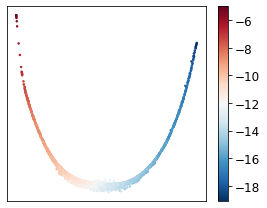

In [35]:
for group in [1,2,3]:
    scprep.plot.scatter2d(batch_gene_phate, c=cluster_specificity_scores[group], cmap='RdBu_r',
                      ticks=None, figsize=(4,3),
                      filename=f'figures/{group}_distance.png', dpi=500)